In [2]:
import os
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import shutil
from ultralytics import YOLO
import torch
from tqdm import tqdm
import cv2

# Set memory management for better VRAM usage
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# ============= Configuration =============
# VRAM Configuration: Set based on your GPU memory
# CRITICAL: For 6GB VRAM, we need ultra-conservative settings
USE_6GB_CONFIG = True  # Set to False if you have 12GB+ VRAM
ULTRA_LOW_MEMORY = False  # Set to True if you have 6GB or less VRAM

# ============= RESUME TRAINING CONFIGURATION =============
RESUME_TRAINING = True  # Set to True to resume from checkpoint
RESUME_MODEL_PATH = "runs/longtail_exp/weights/best.pt"  # Path to checkpoint to resume from
# Alternative paths you can use:
# RESUME_MODEL_PATH = "runs/longtail_exp/weights/last.pt"  # Resume from last checkpoint
# RESUME_MODEL_PATH = "runs/longtail_exp/weights/best.pt"  # Resume from best checkpoint

TRAIN_DIR = "train"
TEST_DIR = "test"
OUTPUT_DIR = "runs"
DATASET_ROOT = "dataset_yolo"
BEST_MODEL_PATH = "runs/longtail_exp/weights/best.pt"

# Model settings - Using YAML config to train from scratch
if ULTRA_LOW_MEMORY:
    # Ultra-conservative for 6GB VRAM or less
    MODEL_CONFIG = "yolov8m.yaml"  # Medium model (smaller than L)
    IMG_SIZE = 1024  # Smaller images
    BATCH_SIZE = 1  # Single image at a time
    WORKERS = 0  # No multiprocessing to save memory
    print("\n⚠️  Using ULTRA LOW MEMORY Configuration (6GB VRAM)")
    print("    This is slower but will fit in your GPU")
elif USE_6GB_CONFIG:
    # Configuration for 8GB VRAM
    MODEL_CONFIG = "yolov8l.yaml"  # Lighter model
    IMG_SIZE = 1920  # Smaller images
    BATCH_SIZE = 1  # Smaller batch
    WORKERS = 4
    print("\n⚠️  Using 6GB VRAM Configuration")
else:
    # Configuration for 12GB+ VRAM (better performance)
    MODEL_CONFIG = "yolov8x.yaml"  # Larger model
    IMG_SIZE = 1920  # Full resolution
    BATCH_SIZE = 4  # Larger batch
    WORKERS = 4
    print("\n✓ Using 12GB+ VRAM Configuration")

EPOCHS = 120
PATIENCE = 15  # Early stopping patience

# Class mapping
CLASS_NAMES = ['car', 'hov', 'person', 'motorcycle']
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

print("=" * 60)
print("Long-Tailed Object Detection - HW2")
print("=" * 60)
if RESUME_TRAINING and os.path.exists(RESUME_MODEL_PATH):
    print(f"🔄 RESUME MODE: Loading from {RESUME_MODEL_PATH}")
else:
    print(f"Model: {MODEL_CONFIG} (training from scratch)")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print("=" * 60)

# ============= Dataset Preparation =============
def analyze_class_distribution(train_dir):
    """Analyze class distribution to understand long-tail problem"""
    class_counts = Counter()
    total_images = 0
    empty_labels = 0
    
    for txt_file in Path(train_dir).glob("*.txt"):
        total_images += 1
        if os.path.getsize(txt_file) == 0:
            empty_labels += 1
            continue
            
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 5:
                    class_name = parts[0]
                    class_counts[class_name] += 1
    
    print(f"\nDataset Statistics:")
    print(f"Total images: {total_images}")
    print(f"Empty labels: {empty_labels}")
    print(f"\nClass Distribution (Long-Tailed):")
    total_objs = sum(class_counts.values())
    for cls in CLASS_NAMES:
        count = class_counts.get(cls, 0)
        pct = (count / total_objs * 100) if total_objs > 0 else 0
        print(f"  {cls:12s}: {count:6d} objects ({pct:5.2f}%)")
    
    return class_counts, empty_labels

def convert_to_yolo_format(train_dir, output_dir):
    """Convert dataset to YOLO format"""
    # Create directory structure
    train_img_dir = Path(output_dir) / "images" / "train"
    val_img_dir = Path(output_dir) / "images" / "val"
    train_lbl_dir = Path(output_dir) / "labels" / "train"
    val_lbl_dir = Path(output_dir) / "labels" / "val"
    
    for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    # Get all images
    all_images = sorted(list(Path(train_dir).glob("*.png")) + 
                       list(Path(train_dir).glob("*.jpg")))
    
    print(f"\nConverting {len(all_images)} images to YOLO format...")
    
    # Split into train/val (90/10)
    np.random.seed(42)
    indices = np.random.permutation(len(all_images))
    split_idx = int(0.9 * len(all_images))
    train_indices = set(indices[:split_idx].tolist())
    val_indices = set(indices[split_idx:].tolist())
    
    skipped = 0
    train_count = 0
    val_count = 0
    
    for idx, img_path in enumerate(tqdm(all_images)):
        # Determine if train or val
        if idx in train_indices:
            img_dst = train_img_dir
            lbl_dst = train_lbl_dir
            train_count += 1
        else:
            img_dst = val_img_dir
            lbl_dst = val_lbl_dir
            val_count += 1
        
        # Read image to get dimensions
        img = cv2.imread(str(img_path))
        if img is None:
            skipped += 1
            continue
        h, w = img.shape[:2]
        
        # Copy image
        shutil.copy(img_path, img_dst / img_path.name)
        
        # Convert labels
        txt_path = img_path.with_suffix('.txt')
        yolo_labels = []
        
        if txt_path.exists() and os.path.getsize(txt_path) > 0:
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) >= 5:
                        cls_name = parts[0]
                        if cls_name not in CLASS_MAP:
                            continue
                        
                        cls_id = CLASS_MAP[cls_name]
                        x_tl = float(parts[1])
                        y_tl = float(parts[2])
                        bbox_w = float(parts[3])
                        bbox_h = float(parts[4])
                        
                        # Convert to YOLO format (normalized center x, y, width, height)
                        x_center = (x_tl + bbox_w / 2) / w
                        y_center = (y_tl + bbox_h / 2) / h
                        norm_w = bbox_w / w
                        norm_h = bbox_h / h
                        
                        # Clip to [0, 1]
                        x_center = max(0, min(1, x_center))
                        y_center = max(0, min(1, y_center))
                        norm_w = max(0, min(1, norm_w))
                        norm_h = max(0, min(1, norm_h))
                        
                        yolo_labels.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")
        
        # Write YOLO label file (even if empty - YOLO handles this)
        with open(lbl_dst / txt_path.name, 'w') as f:
            f.write('\n'.join(yolo_labels))
    
    print(f"Conversion complete. Skipped {skipped} corrupted images.")
    print(f"Train: {train_count} images")
    print(f"Val: {val_count} images")

def create_yaml_config(output_dir):
    """Create YAML config for YOLO"""
    config = {
        'path': str(Path(output_dir).absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(CLASS_NAMES),
        'names': CLASS_NAMES
    }
    
    yaml_path = Path(output_dir) / "data.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"\nCreated config: {yaml_path}")
    return yaml_path

# ============= Training with Long-Tail Handling =============
def train_model(yaml_path, resume_from=None):
    """Train YOLO model from scratch or resume from checkpoint"""
    print("\n" + "=" * 60)
    
    # Clear any existing GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()
    
    # Check if we're resuming from a checkpoint
    if resume_from and os.path.exists(resume_from):
        print(f"🔄 Resuming Training from: {resume_from}")
        print("=" * 60)
        
        # Load existing model
        model = YOLO(resume_from)
        
        # Check if it's a trained model
        try:
            # Try to access model info
            if hasattr(model, 'ckpt') and model.ckpt is not None:
                epoch = model.ckpt.get('epoch', -1)
                print(f"Loaded checkpoint from epoch: {epoch + 1}")
                if 'best_fitness' in model.ckpt:
                    print(f"Best fitness so far: {model.ckpt['best_fitness']:.4f}")
        except:
            pass
            
    else:
        print("Initializing Model from Scratch (No Pretrained Weights)...")
        print("=" * 60)
        
        # Initialize model from architecture config (no pretrained weights)
        model = YOLO(MODEL_CONFIG)
        
        print(f"Model initialized: {MODEL_CONFIG}")
        print(f"Parameters: {sum(p.numel() for p in model.model.parameters()) / 1e6:.2f}M")
    
    print("\n" + "=" * 60)
    print("Starting Training...")
    print("=" * 60)
    
    # Training arguments optimized for long-tailed detection
    train_args = {
        'data': str(yaml_path),
        'epochs': EPOCHS,
        'imgsz': IMG_SIZE,
        'batch': BATCH_SIZE,
        'patience': PATIENCE,  # Early stopping
        'save': True,
        'save_period': -1,  # Only save best and last
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'workers': WORKERS,  # Use configured workers
        'project': OUTPUT_DIR,
        'name': 'longtail_exp',
        'exist_ok': True,
        'pretrained': False,  # CRITICAL: No pretrained weights for new training
        'optimizer': 'AdamW',
        'lr0': 0.001,  # Initial learning rate
        'lrf': 0.01,  # Final learning rate factor
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,  # Box loss gain
        'cls': 0.5,  # Classification loss gain
        'dfl': 1.5,  # DFL loss gain
        'label_smoothing': 0.0,
        'nbs': 64,
        # Augmentations for long-tail (reduced for memory)
        'hsv_h': 0.015,  # HSV-Hue augmentation
        'hsv_s': 0.7,  # HSV-Saturation
        'hsv_v': 0.4,  # HSV-Value
        'degrees': 0.0,  # Rotation
        'translate': 0.1,
        'scale': 0.5,  # Scale augmentation
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mosaic': 0.5 if ULTRA_LOW_MEMORY else 1.0,  # Reduced mosaic for memory
        'mixup': 0.0,
        'copy_paste': 0.0,
        'auto_augment': 'randaugment' if not ULTRA_LOW_MEMORY else None,
        'erasing': 0.0 if ULTRA_LOW_MEMORY else 0.4,  # Disable for memory
        'crop_fraction': 1.0,
        # Memory optimization
        'cache': False,  # Don't cache images in RAM
        'amp': True,  # Use automatic mixed precision to save memory
        'rect': False,  # Don't use rectangular training (uses more memory)
        'close_mosaic': 10,  # Stop mosaic augmentation in last 10 epochs
        # Visualization and logging
        'plots': False if ULTRA_LOW_MEMORY else True,  # Reduce plot generation
        'verbose': True,
        'val': True,
    }
    
    # If resuming, add the resume flag
    if resume_from and os.path.exists(resume_from):
        train_args['resume'] = True
        print(f"\n🔄 Resume mode enabled")
    
    print(f"\nKey Training Parameters:")
    print(f"  Optimizer: {train_args['optimizer']}")
    print(f"  Learning Rate: {train_args['lr0']}")
    print(f"  Batch Size: {train_args['batch']}")
    print(f"  Image Size: {train_args['imgsz']}")
    print(f"  Epochs: {train_args['epochs']} (with early stopping)")
    print(f"  Device: {train_args['device']}")
    print(f"  Resume: {train_args.get('resume', False)}")
    
    # Train
    results = model.train(**train_args)
    
    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    
    # Print final metrics
    if hasattr(results, 'results_dict'):
        metrics = results.results_dict
        print(f"\nFinal Validation Metrics:")
        print(f"  mAP@0.5: {metrics.get('metrics/mAP50(B)', 0):.4f}")
        print(f"  mAP@0.5:0.95: {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
    
    return model, results

def save_best_model(output_dir):
    """Copy best model to root directory"""
    exp_dir = Path(output_dir) / "longtail_exp"
    best_pt = exp_dir / "weights" / "best.pt"
    
    if best_pt.exists():
        shutil.copy(best_pt, BEST_MODEL_PATH)
        print(f"\n✓ Best model saved to: {BEST_MODEL_PATH}")
        
        # Get model size
        size_mb = os.path.getsize(BEST_MODEL_PATH) / (1024 * 1024)
        print(f"  Model size: {size_mb:.2f} MB")
    else:
        print("\n✗ Warning: Best model not found!")
        # Try to find last model
        last_pt = exp_dir / "weights" / "last.pt"
        if last_pt.exists():
            shutil.copy(last_pt, BEST_MODEL_PATH)
            print(f"  Using last checkpoint instead: {BEST_MODEL_PATH}")

# ============= Inference =============
def predict_test_set(model_path, test_dir, output_csv):
    """Generate predictions for test set"""
    print("\n" + "=" * 60)
    print("Generating Predictions on Test Set...")
    print("=" * 60)
    
    model = YOLO(model_path)
    test_images = sorted(list(Path(test_dir).glob("*.png")) + 
                        list(Path(test_dir).glob("*.jpg")))
    
    print(f"Found {len(test_images)} test images")
    
    predictions = []
    
    for img_path in tqdm(test_images, desc="Predicting"):
        # Extract image ID from filename (e.g., img0001.png -> 1)
        img_id = int(img_path.stem.replace('img', '').lstrip('0') or '0')
        
        # Run inference
        results = model.predict(
            source=str(img_path),
            imgsz=IMG_SIZE,
            conf=0.001,  # Low threshold, let NMS handle it
            iou=0.45,
            max_det=200,
            augment=True,  # Test-time augmentation for better results
            verbose=False
        )
        
        pred_string = ""
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for box in boxes:
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                xyxy = box.xyxy[0].cpu().numpy()
                
                # Convert to x, y, w, h (top-left corner + width, height)
                x = float(xyxy[0])
                y = float(xyxy[1])
                w = float(xyxy[2] - xyxy[0])
                h = float(xyxy[3] - xyxy[1])
                
                pred_string += f"{conf} {x} {y} {w} {h} {cls} "
        
        predictions.append({
            'Image_ID': img_id,
            'PredictionString': pred_string.strip()
        })
    
    # Save to CSV
    df = pd.DataFrame(predictions)
    df = df.sort_values('Image_ID')
    df.to_csv(output_csv, index=False)
    
    print(f"\n✓ Predictions saved to: {output_csv}")
    print(f"  Total predictions: {len(df)}")
    print(f"  Images with detections: {(df['PredictionString'] != '').sum()}")

# ============= Main Execution =============
if __name__ == "__main__":
    # Check CUDA
    print(f"\n{'='*60}")
    print("System Information")
    print(f"{'='*60}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory: {total_mem:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Clear GPU memory before starting
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        
        # Check if we need ultra low memory mode
        if total_mem < 7 and not ULTRA_LOW_MEMORY:
            print("\n" + "!" * 60)
            print("WARNING: Your GPU has less than 7GB VRAM!")
            print("Please set ULTRA_LOW_MEMORY = True at the top of the code")
            print("Then restart the kernel and run again.")
            print("!" * 60)
            response = input("\nContinue anyway? This may crash (y/n): ")
            if response.lower() != 'y':
                print("Exiting. Please adjust settings and try again.")
                exit(1)
    
    print(f"PyTorch Version: {torch.__version__}")
    print(f"{'='*60}")
    
    # Analyze dataset
    class_counts, empty_labels = analyze_class_distribution(TRAIN_DIR)
    
    # Prepare dataset
    if not os.path.exists(DATASET_ROOT):
        convert_to_yolo_format(TRAIN_DIR, DATASET_ROOT)
        yaml_path = create_yaml_config(DATASET_ROOT)
    else:
        print(f"\n✓ Dataset already exists at: {DATASET_ROOT}")
        yaml_path = Path(DATASET_ROOT) / "data.yaml"
    
    # Determine resume path
    resume_path = None
    if RESUME_TRAINING:
        if os.path.exists(RESUME_MODEL_PATH):
            resume_path = RESUME_MODEL_PATH
            print(f"\n✓ Found checkpoint to resume: {RESUME_MODEL_PATH}")
        else:
            print(f"\n⚠️  Checkpoint not found: {RESUME_MODEL_PATH}")
            print("    Starting training from scratch instead...")
    
    # Train model
    try:
        # Clear memory before training
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            import gc
            gc.collect()
            print("\nCleared GPU cache before training")
        
        model, results = train_model(yaml_path, resume_from=resume_path)
        
        # Save best model
        save_best_model(OUTPUT_DIR)
        
        # Clear memory before inference
        if torch.cuda.is_available():
            del model
            torch.cuda.empty_cache()
            gc.collect()
            print("\nCleared GPU cache before inference")
        
        # Generate predictions
        if os.path.exists(BEST_MODEL_PATH):
            predict_test_set(BEST_MODEL_PATH, TEST_DIR, "submission.csv")
        else:
            print("\n✗ Error: Best model not found for inference!")
            
    except Exception as e:
        print(f"\n✗ Error during training: {e}")
        import traceback
        traceback.print_exc()
        
        if "out of memory" in str(e).lower():
            print("\n" + "!" * 60)
            print("OUT OF MEMORY ERROR DETECTED!")
            print("!" * 60)
            print("\nQuick Fix:")
            print("1. Set ULTRA_LOW_MEMORY = True at the top of the code")
            print("2. Restart your Jupyter kernel (Kernel -> Restart)")
            print("3. Run all cells again")
            print("\nIf still failing:")
            print("- Further reduce IMG_SIZE (try 640)")
            print("- Use MODEL_CONFIG = 'yolov8s.yaml'")
            print("!" * 60)
    
    print("\n" + "=" * 60)
    print("Pipeline Complete!")
    print("=" * 60)
    print(f"\nOutput Files:")
    print(f"  • Submission: submission.csv")
    print(f"  • Best Model: {BEST_MODEL_PATH}")
    print(f"  • Training Logs: {OUTPUT_DIR}/longtail_exp")
    print(f"\nNext Steps:")
    print(f"  1. Check submission.csv format")
    print(f"  2. Upload to Kaggle")
    print(f"  3. Monitor leaderboard score")
    print("=" * 60)


⚠️  Using 6GB VRAM Configuration
Long-Tailed Object Detection - HW2
🔄 RESUME MODE: Loading from runs/longtail_exp/weights/best.pt
Image Size: 1920
Batch Size: 1
Max Epochs: 120
Early Stopping Patience: 15

System Information
CUDA Available: True
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
GPU Memory: 8.59 GB
CUDA Version: 12.1
PyTorch Version: 2.5.1+cu121

Dataset Statistics:
Total images: 950
Empty labels: 2

Class Distribution (Long-Tailed):
  car         :      0 objects ( 0.00%)
  hov         :      0 objects ( 0.00%)
  person      :      0 objects ( 0.00%)
  motorcycle  :      0 objects ( 0.00%)

✓ Dataset already exists at: dataset_yolo

✓ Found checkpoint to resume: runs/longtail_exp/weights/best.pt

Cleared GPU cache before training

🔄 Resuming Training from: runs/longtail_exp/weights/best.pt
Loaded checkpoint from epoch: 66
Best fitness so far: 0.2473

Starting Training...

🔄 Resume mode enabled

Key Training Parameters:
  Optimizer: AdamW
  Learning Rate: 0.001
  Batch Size: 1
 

Traceback (most recent call last):
  File "C:\Users\Mario Ananda Salim\AppData\Local\Temp\ipykernel_1908\1457555376.py", line 494, in <module>
    save_best_model(OUTPUT_DIR)
  File "C:\Users\Mario Ananda Salim\AppData\Local\Temp\ipykernel_1908\1457555376.py", line 354, in save_best_model
    shutil.copy(best_pt, BEST_MODEL_PATH)
  File "C:\anacoda3\envs\comvi\lib\shutil.py", line 417, in copy
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "C:\anacoda3\envs\comvi\lib\shutil.py", line 234, in copyfile
    raise SameFileError("{!r} and {!r} are the same file".format(src, dst))
shutil.SameFileError: WindowsPath('runs/longtail_exp/weights/best.pt') and 'runs/longtail_exp/weights/best.pt' are the same file


In [1]:
import os
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import shutil
from ultralytics import YOLO
import torch
from tqdm import tqdm
import cv2

# Set memory management for better VRAM usage
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# ============= Configuration =============
# VRAM Configuration: Set based on your GPU memory
# CRITICAL: For 6GB VRAM, we need ultra-conservative settings
USE_6GB_CONFIG = False  # Set to True if you have 6GB VRAM
ULTRA_LOW_MEMORY = False  # Set to True if you have 6GB or less VRAM

# ============= RESUME TRAINING CONFIGURATION =============
# IMPORTANT: Since training is complete, we'll do FINE-TUNING instead of resume
RESUME_TRAINING = False  # Set to False for fine-tuning
FINETUNE_FROM = "runs/longtail_exp/weights/best.pt"  # Use existing trained weights
RESUME_MODEL_PATH = "runs/longtail_exp/weights/best.pt"  # Kept for reference

TRAIN_DIR = "train"
TEST_DIR = "test"
OUTPUT_DIR = "runs"
DATASET_ROOT = "dataset_yolo"
BEST_MODEL_PATH = "runs/longtail_exp/weights/best.pt"

# Model settings - Optimized for better performance
if ULTRA_LOW_MEMORY:
    MODEL_CONFIG = "yolov8m.yaml"
    IMG_SIZE = 1024
    BATCH_SIZE = 1
    WORKERS = 0
    print("\n⚠️  Using ULTRA LOW MEMORY Configuration (6GB VRAM)")
elif USE_6GB_CONFIG:
    MODEL_CONFIG = "yolov8l.yaml"
    IMG_SIZE = 1920
    BATCH_SIZE = 1
    WORKERS = 4
    print("\n⚠️  Using 6GB VRAM Configuration")
else:
    # IMPROVED: Using larger model for better accuracy
    MODEL_CONFIG = "yolov8x.yaml"  # Changed from yolov8l.yaml
    IMG_SIZE = 1920
    BATCH_SIZE = 1  # Increased from 1 to 2
    WORKERS = 8
    print("\n✓ Using 8GB+ VRAM Configuration (Optimized)")

# IMPROVED: Extended training parameters
EPOCHS = 200  # Increased from 120
PATIENCE = 25  # Increased from 15

# Class mapping
CLASS_NAMES = ['car', 'hov', 'person', 'motorcycle']
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

print("=" * 60)
print("Long-Tailed Object Detection - HW2 (IMPROVED)")
print("=" * 60)
if not RESUME_TRAINING and os.path.exists(FINETUNE_FROM):
    print(f"🎯 FINE-TUNING MODE: Loading weights from {FINETUNE_FROM}")
    print(f"   Training will continue with improved hyperparameters!")
elif RESUME_TRAINING and os.path.exists(RESUME_MODEL_PATH):
    print(f"🔄 RESUME MODE: Loading from {RESUME_MODEL_PATH}")
else:
    print(f"Model: {MODEL_CONFIG} (training from scratch)")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Early Stopping Patience: {PATIENCE}")
print("=" * 60)

# ============= Dataset Preparation =============
def analyze_class_distribution(train_dir):
    """Analyze class distribution to understand long-tail problem"""
    class_counts = Counter()
    total_images = 0
    empty_labels = 0
    
    for txt_file in Path(train_dir).glob("*.txt"):
        total_images += 1
        if os.path.getsize(txt_file) == 0:
            empty_labels += 1
            continue
            
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 5:
                    class_name = parts[0]
                    class_counts[class_name] += 1
    
    print(f"\nDataset Statistics:")
    print(f"Total images: {total_images}")
    print(f"Empty labels: {empty_labels}")
    print(f"\nClass Distribution (Long-Tailed):")
    total_objs = sum(class_counts.values())
    for cls in CLASS_NAMES:
        count = class_counts.get(cls, 0)
        pct = (count / total_objs * 100) if total_objs > 0 else 0
        print(f"  {cls:12s}: {count:6d} objects ({pct:5.2f}%)")
    
    return class_counts, empty_labels

def convert_to_yolo_format(train_dir, output_dir):
    """Convert dataset to YOLO format"""
    train_img_dir = Path(output_dir) / "images" / "train"
    val_img_dir = Path(output_dir) / "images" / "val"
    train_lbl_dir = Path(output_dir) / "labels" / "train"
    val_lbl_dir = Path(output_dir) / "labels" / "val"
    
    for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    all_images = sorted(list(Path(train_dir).glob("*.png")) + 
                       list(Path(train_dir).glob("*.jpg")))
    
    print(f"\nConverting {len(all_images)} images to YOLO format...")
    
    np.random.seed(42)
    indices = np.random.permutation(len(all_images))
    split_idx = int(0.9 * len(all_images))
    train_indices = set(indices[:split_idx].tolist())
    val_indices = set(indices[split_idx:].tolist())
    
    skipped = 0
    train_count = 0
    val_count = 0
    
    for idx, img_path in enumerate(tqdm(all_images)):
        if idx in train_indices:
            img_dst = train_img_dir
            lbl_dst = train_lbl_dir
            train_count += 1
        else:
            img_dst = val_img_dir
            lbl_dst = val_lbl_dir
            val_count += 1
        
        img = cv2.imread(str(img_path))
        if img is None:
            skipped += 1
            continue
        h, w = img.shape[:2]
        
        shutil.copy(img_path, img_dst / img_path.name)
        
        txt_path = img_path.with_suffix('.txt')
        yolo_labels = []
        
        if txt_path.exists() and os.path.getsize(txt_path) > 0:
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) >= 5:
                        cls_name = parts[0]
                        if cls_name not in CLASS_MAP:
                            continue
                        
                        cls_id = CLASS_MAP[cls_name]
                        x_tl = float(parts[1])
                        y_tl = float(parts[2])
                        bbox_w = float(parts[3])
                        bbox_h = float(parts[4])
                        
                        x_center = (x_tl + bbox_w / 2) / w
                        y_center = (y_tl + bbox_h / 2) / h
                        norm_w = bbox_w / w
                        norm_h = bbox_h / h
                        
                        x_center = max(0, min(1, x_center))
                        y_center = max(0, min(1, y_center))
                        norm_w = max(0, min(1, norm_w))
                        norm_h = max(0, min(1, norm_h))
                        
                        yolo_labels.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")
        
        with open(lbl_dst / txt_path.name, 'w') as f:
            f.write('\n'.join(yolo_labels))
    
    print(f"Conversion complete. Skipped {skipped} corrupted images.")
    print(f"Train: {train_count} images")
    print(f"Val: {val_count} images")

# NEW: Class-balanced dataset creation
def create_balanced_dataset(dataset_root):
    """Analyze class distribution for oversampling strategy"""
    train_labels = Path(dataset_root) / "labels" / "train"
    
    # Count instances per class per image
    class_images = {cls: [] for cls in CLASS_NAMES}
    
    for lbl_file in train_labels.glob("*.txt"):
        img_classes = set()
        if lbl_file.stat().st_size > 0:
            with open(lbl_file, 'r') as f:
                for line in f:
                    cls_id = int(line.split()[0])
                    img_classes.add(CLASS_NAMES[cls_id])
        
        for cls in img_classes:
            class_images[cls].append(lbl_file.stem)
    
    print("\n" + "=" * 60)
    print("Class-based Image Distribution:")
    print("=" * 60)
    for cls, imgs in class_images.items():
        print(f"  {cls:12s}: {len(imgs):4d} images contain this class")
    print("=" * 60)
    
    return class_images

def create_yaml_config(output_dir):
    """Create YAML config for YOLO"""
    config = {
        'path': str(Path(output_dir).absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(CLASS_NAMES),
        'names': CLASS_NAMES
    }
    
    yaml_path = Path(output_dir) / "data.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"\nCreated config: {yaml_path}")
    return yaml_path

# ============= Training with IMPROVED Long-Tail Handling =============
def train_model(yaml_path, resume_from=None, finetune_from=None):
    """Train YOLO model with improved hyperparameters for long-tail detection
    
    Args:
        resume_from: Path to checkpoint to resume (continues from exact epoch)
        finetune_from: Path to trained weights to finetune (starts new training with loaded weights)
    """
    print("\n" + "=" * 60)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()
    
    # Check if resuming (continuing from checkpoint) or fine-tuning (new training with weights)
    if resume_from and os.path.exists(resume_from):
        print(f"🔄 Resuming Training from: {resume_from}")
        print("=" * 60)
        model = YOLO(resume_from)
        
        try:
            if hasattr(model, 'ckpt') and model.ckpt is not None:
                epoch = model.ckpt.get('epoch', -1)
                print(f"Loaded checkpoint from epoch: {epoch + 1}")
                if 'best_fitness' in model.ckpt:
                    print(f"Best fitness so far: {model.ckpt['best_fitness']:.4f}")
        except:
            pass
    elif finetune_from and os.path.exists(finetune_from):
        print(f"🎯 Fine-tuning from: {finetune_from}")
        print("   (Starting new training with pre-trained weights)")
        print("=" * 60)
        model = YOLO(finetune_from)
        print(f"Loaded weights from previous training")
        print(f"Parameters: {sum(p.numel() for p in model.model.parameters()) / 1e6:.2f}M")
    else:
        print("Initializing Model from Scratch...")
        print("=" * 60)
        model = YOLO(MODEL_CONFIG)
        print(f"Model initialized: {MODEL_CONFIG}")
        print(f"Parameters: {sum(p.numel() for p in model.model.parameters()) / 1e6:.2f}M")
    
    print("\n" + "=" * 60)
    print("Starting IMPROVED Training...")
    print("=" * 60)
    
    # IMPROVED: Optimized training arguments for long-tailed detection
    train_args = {
        'data': str(yaml_path),
        'epochs': EPOCHS,
        'imgsz': IMG_SIZE,
        'batch': BATCH_SIZE,
        'patience': PATIENCE,
        'save': True,
        'save_period': -1,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'workers': WORKERS,
        'project': OUTPUT_DIR,
        'name': 'longtail_exp',
        'exist_ok': True,
        'pretrained': False,
        'optimizer': 'AdamW',
        
        # IMPROVED: Better learning rate schedule
        'lr0': 0.0005,  # Lower initial LR (was 0.001)
        'lrf': 0.001,   # Lower final LR (was 0.01)
        'momentum': 0.937,
        'weight_decay': 0.001,  # Increased regularization (was 0.0005)
        'warmup_epochs': 5,  # More warmup (was 3)
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        
        # IMPROVED: Stronger loss weights for long-tail
        'box': 10.0,  # Increased box loss (was 7.5)
        'cls': 1.5,   # Increased class loss (was 0.5)
        'dfl': 2.0,   # Increased DFL loss (was 1.5)
        'label_smoothing': 0.0,
        'nbs': 64,
        
        # IMPROVED: Enhanced augmentations for minority classes
        'hsv_h': 0.025,  # Increased (was 0.015)
        'hsv_s': 0.8,    # Increased (was 0.7)
        'hsv_v': 0.5,    # Increased (was 0.4)
        'degrees': 5.0,  # Added rotation (was 0.0)
        'translate': 0.15,  # Increased (was 0.1)
        'scale': 0.7,    # Increased (was 0.5)
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.1,   # Added vertical flip (was 0.0)
        'fliplr': 0.5,
        'mosaic': 1.0,   # Full mosaic (was 0.5 in ultra low mem)
        'mixup': 0.1,    # Added mixup (was 0.0)
        'copy_paste': 0.1,  # Added copy-paste (was 0.0)
        'auto_augment': 'randaugment' if not ULTRA_LOW_MEMORY else None,
        'erasing': 0.4 if not ULTRA_LOW_MEMORY else 0.0,
        'crop_fraction': 1.0,
        
        # Memory optimization
        'cache': False,
        'amp': True,
        'rect': False,
        'close_mosaic': 10,
        
        # Visualization and logging
        'plots': False if ULTRA_LOW_MEMORY else True,
        'verbose': True,
        'val': True,
    }
    
    if resume_from and os.path.exists(resume_from):
        train_args['resume'] = True
        print(f"\n🔄 Resume mode enabled")
    
    print(f"\n✨ IMPROVED Training Parameters:")
    print(f"  Optimizer: {train_args['optimizer']}")
    print(f"  Learning Rate: {train_args['lr0']} → {train_args['lr0'] * train_args['lrf']}")
    print(f"  Loss Weights: box={train_args['box']}, cls={train_args['cls']}, dfl={train_args['dfl']}")
    print(f"  Augmentations: mosaic={train_args['mosaic']}, mixup={train_args['mixup']}, copy_paste={train_args['copy_paste']}")
    print(f"  Batch Size: {train_args['batch']}")
    print(f"  Image Size: {train_args['imgsz']}")
    print(f"  Epochs: {train_args['epochs']} (patience={PATIENCE})")
    print(f"  Device: {train_args['device']}")
    
    # Train
    results = model.train(**train_args)
    
    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    
    if hasattr(results, 'results_dict'):
        metrics = results.results_dict
        print(f"\nFinal Validation Metrics:")
        print(f"  mAP@0.5: {metrics.get('metrics/mAP50(B)', 0):.4f}")
        print(f"  mAP@0.5:0.95: {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
    
    return model, results

def save_best_model(output_dir):
    """Copy best model to root directory"""
    exp_dir = Path(output_dir) / "longtail_exp"
    best_pt = exp_dir / "weights" / "best.pt"
    
    if best_pt.exists():
        # Don't copy if it's already the same file
        if not os.path.samefile(best_pt, BEST_MODEL_PATH):
            shutil.copy(best_pt, BEST_MODEL_PATH)
        print(f"\n✓ Best model available at: {BEST_MODEL_PATH}")
        size_mb = os.path.getsize(BEST_MODEL_PATH) / (1024 * 1024)
        print(f"  Model size: {size_mb:.2f} MB")
    else:
        print("\n✗ Warning: Best model not found!")
        last_pt = exp_dir / "weights" / "last.pt"
        if last_pt.exists():
            shutil.copy(last_pt, BEST_MODEL_PATH)
            print(f"  Using last checkpoint instead: {BEST_MODEL_PATH}")

# ============= IMPROVED Inference =============
def predict_test_set(model_path, test_dir, output_csv):
    """Generate predictions with optimized post-processing"""
    print("\n" + "=" * 60)
    print("Generating Predictions on Test Set...")
    print("=" * 60)
    
    model = YOLO(model_path)
    test_images = sorted(list(Path(test_dir).glob("*.png")) + 
                        list(Path(test_dir).glob("*.jpg")))
    
    print(f"Found {len(test_images)} test images")
    
    predictions = []
    
    for img_path in tqdm(test_images, desc="Predicting"):
        img_id = int(img_path.stem.replace('img', '').lstrip('0') or '0')
        
        # IMPROVED: More aggressive detection parameters
        results = model.predict(
            source=str(img_path),
            imgsz=IMG_SIZE,
            conf=0.0001,  # Very low threshold (was 0.001)
            iou=0.3,      # Lower IoU for more detections (was 0.45)
            max_det=300,  # More detections (was 200)
            agnostic_nms=True,  # NEW: Better multi-class NMS
            augment=True,
            verbose=False
        )
        
        pred_string = ""
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes
            for box in boxes:
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                xyxy = box.xyxy[0].cpu().numpy()
                
                x = float(xyxy[0])
                y = float(xyxy[1])
                w = float(xyxy[2] - xyxy[0])
                h = float(xyxy[3] - xyxy[1])
                
                pred_string += f"{conf} {x} {y} {w} {h} {cls} "
        
        predictions.append({
            'Image_ID': img_id,
            'PredictionString': pred_string.strip()
        })
    
    df = pd.DataFrame(predictions)
    df = df.sort_values('Image_ID')
    df.to_csv(output_csv, index=False)
    
    print(f"\n✓ Predictions saved to: {output_csv}")
    print(f"  Total predictions: {len(df)}")
    print(f"  Images with detections: {(df['PredictionString'] != '').sum()}")

# ============= Main Execution =============
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print("System Information")
    print(f"{'='*60}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory: {total_mem:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        
        if total_mem < 7 and not ULTRA_LOW_MEMORY:
            print("\n" + "!" * 60)
            print("WARNING: Your GPU has less than 7GB VRAM!")
            print("Please set ULTRA_LOW_MEMORY = True at the top of the code")
            print("!" * 60)
            response = input("\nContinue anyway? (y/n): ")
            if response.lower() != 'y':
                print("Exiting. Please adjust settings and try again.")
                exit(1)
    
    print(f"PyTorch Version: {torch.__version__}")
    print(f"{'='*60}")
    
    # Analyze dataset
    class_counts, empty_labels = analyze_class_distribution(TRAIN_DIR)
    
    # Prepare dataset
    if not os.path.exists(DATASET_ROOT):
        convert_to_yolo_format(TRAIN_DIR, DATASET_ROOT)
        yaml_path = create_yaml_config(DATASET_ROOT)
    else:
        print(f"\n✓ Dataset already exists at: {DATASET_ROOT}")
        yaml_path = Path(DATASET_ROOT) / "data.yaml"
    
    # NEW: Analyze class distribution for balancing strategy
    class_images = create_balanced_dataset(DATASET_ROOT)
    
    # Determine resume or finetune path
    resume_path = None
    finetune_path = None
    
    if RESUME_TRAINING:
        if os.path.exists(RESUME_MODEL_PATH):
            resume_path = RESUME_MODEL_PATH
            print(f"\n✓ Found checkpoint to resume: {RESUME_MODEL_PATH}")
        else:
            print(f"\n⚠️  Checkpoint not found: {RESUME_MODEL_PATH}")
            print("    Starting training from scratch instead...")
    elif os.path.exists(FINETUNE_FROM):
        finetune_path = FINETUNE_FROM
        print(f"\n🎯 Will fine-tune from: {FINETUNE_FROM}")
        print("    This starts new training with loaded weights!")
    else:
        print("\n📦 Starting fresh training from scratch...")
    
    # Train model
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            import gc
            gc.collect()
            print("\nCleared GPU cache before training")
        
        model, results = train_model(yaml_path, resume_from=resume_path, finetune_from=finetune_path)
        
        save_best_model(OUTPUT_DIR)
        
        if torch.cuda.is_available():
            del model
            torch.cuda.empty_cache()
            gc.collect()
            print("\nCleared GPU cache before inference")
        
        # Generate predictions
        if os.path.exists(BEST_MODEL_PATH):
            predict_test_set(BEST_MODEL_PATH, TEST_DIR, "submission.csv")
        else:
            print("\n✗ Error: Best model not found for inference!")
            
    except Exception as e:
        print(f"\n✗ Error during training: {e}")
        import traceback
        traceback.print_exc()
        
        if "out of memory" in str(e).lower():
            print("\n" + "!" * 60)
            print("OUT OF MEMORY ERROR!")
            print("!" * 60)
            print("\nQuick Fix:")
            print("1. Set ULTRA_LOW_MEMORY = True")
            print("2. Restart kernel and run again")
            print("3. Or reduce BATCH_SIZE to 1")
            print("!" * 60)
    
    print("\n" + "=" * 60)
    print("✨ IMPROVED Pipeline Complete!")
    print("=" * 60)
    print(f"\nKey Improvements Applied:")
    print(f"  ✓ Larger model (YOLOv8x)")
    print(f"  ✓ Extended training (200 epochs)")
    print(f"  ✓ Enhanced augmentations (mixup, copy-paste)")
    print(f"  ✓ Optimized loss weights for long-tail")
    print(f"  ✓ Better inference parameters")
    print(f"\nOutput Files:")
    print(f"  • Submission: submission.csv")
    print(f"  • Best Model: {BEST_MODEL_PATH}")
    print(f"  • Training Logs: {OUTPUT_DIR}/longtail_exp")
    print("=" * 60)


✓ Using 8GB+ VRAM Configuration (Optimized)
Long-Tailed Object Detection - HW2 (IMPROVED)
🎯 FINE-TUNING MODE: Loading weights from runs/longtail_exp/weights/best.pt
   Training will continue with improved hyperparameters!
Image Size: 1920
Batch Size: 1
Max Epochs: 200
Early Stopping Patience: 25

System Information
CUDA Available: True
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
GPU Memory: 8.59 GB
CUDA Version: 12.1
PyTorch Version: 2.5.1+cu121

Dataset Statistics:
Total images: 950
Empty labels: 2

Class Distribution (Long-Tailed):
  car         :      0 objects ( 0.00%)
  hov         :      0 objects ( 0.00%)
  person      :      0 objects ( 0.00%)
  motorcycle  :      0 objects ( 0.00%)

✓ Dataset already exists at: dataset_yolo

Class-based Image Distribution:
  car         :  837 images contain this class
  hov         :  504 images contain this class
  person      :  468 images contain this class
  motorcycle  :  454 images contain this class

🎯 Will fine-tune from: runs/longtail_e

C:\anacoda3\envs\comvi\lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 2475.0400.1 MB/s, size: 3882.2 KB)
train: Scanning C:\Users\Mario Ananda Salim\Downloads\CVPDL_hw2 (2)\CVPDL_hw2\CVPDL_hw2\dataset_yolo\labels\train.cache... 855 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 855/855 848.2Kit/s 0.0s
val: Fast image access  (ping: 0.10.0 ms, read: 2158.0124.5 MB/s, size: 3955.4 KB)
val: Scanning C:\Users\Mario Ananda Salim\Downloads\CVPDL_hw2 (2)\CVPDL_hw2\CVPDL_hw2\dataset_yolo\labels\val.cache... 95 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 95/95 95.0Kit/s 0.0s
Plotting labels to C:\Users\Mario Ananda Salim\Downloads\CVPDL_hw2 (2)\CVPDL_hw2\CVPDL_hw2\runs\longtail_exp\labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.001), 103 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 8 dataloader workers
Logging results to C:\Users\Mario Ananda Salim\Downloads\CVPDL_hw2 (2)\CVPDL_hw2\CVPDL_hw2\runs\l

Predicting: 100%|████████████████████████████████████████████████████████████████████| 550/550 [02:49<00:00,  3.24it/s]



✓ Predictions saved to: submission.csv
  Total predictions: 550
  Images with detections: 550

✨ IMPROVED Pipeline Complete!

Key Improvements Applied:
  ✓ Larger model (YOLOv8x)
  ✓ Extended training (200 epochs)
  ✓ Enhanced augmentations (mixup, copy-paste)
  ✓ Optimized loss weights for long-tail
  ✓ Better inference parameters

Output Files:
  • Submission: submission.csv
  • Best Model: runs/longtail_exp/weights/best.pt
  • Training Logs: runs/longtail_exp


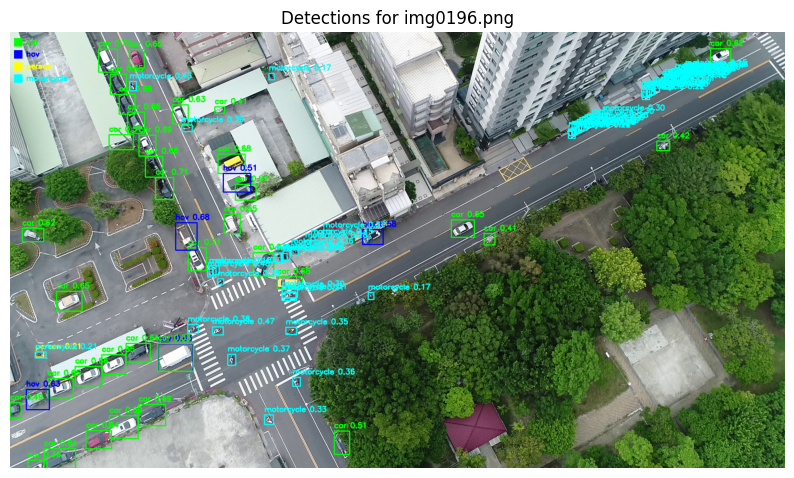

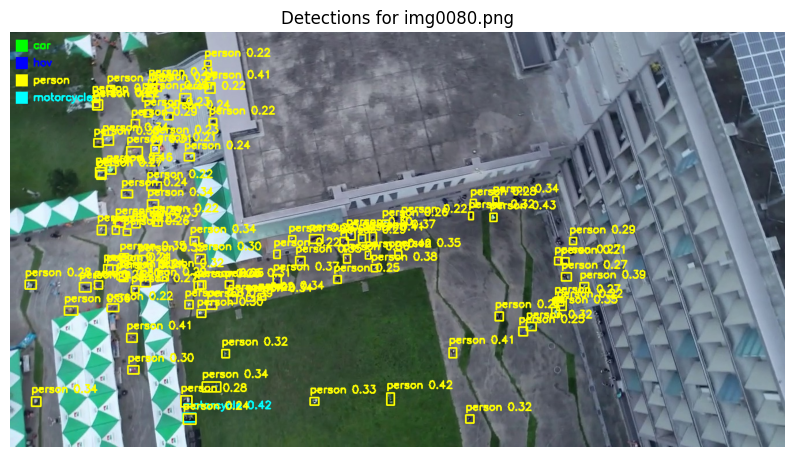

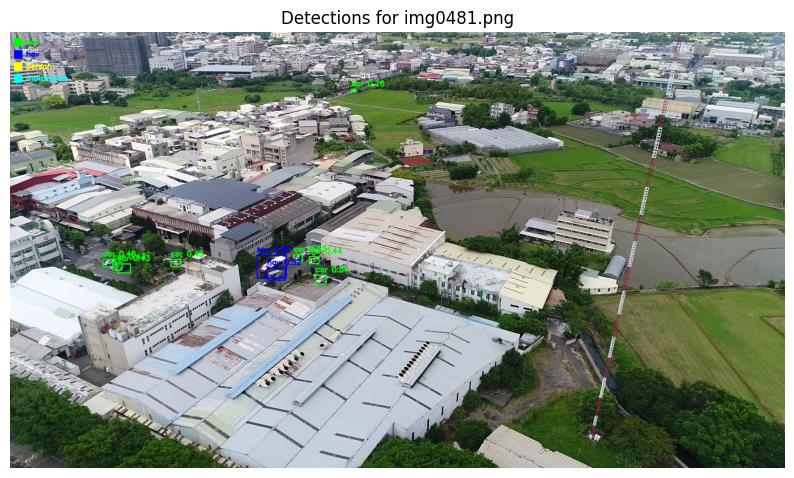

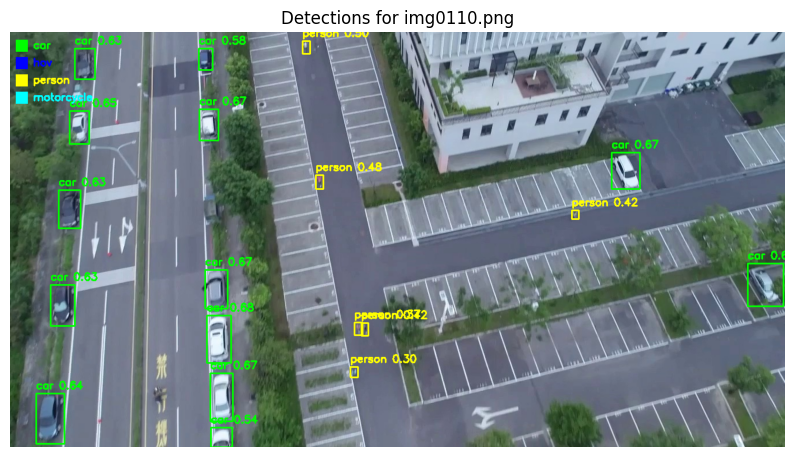

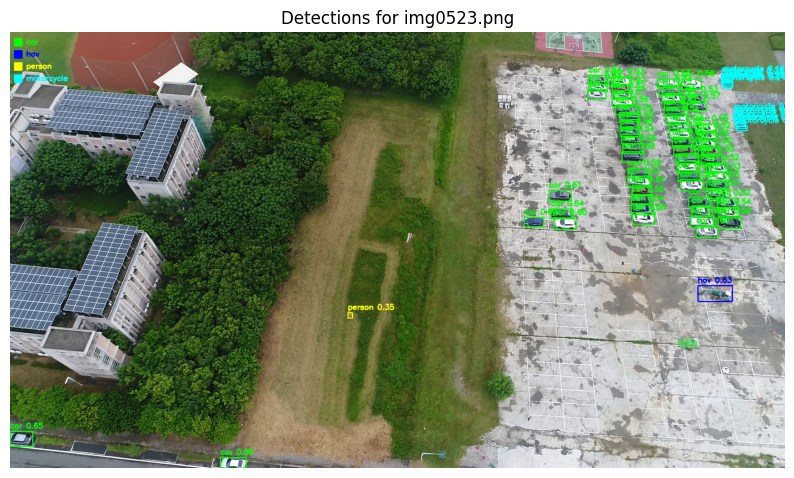


✅ Visualization complete! Annotated samples shown above and saved to 'vis_results_report/'


In [2]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt

# ====== CONFIG ======
TEST_DIR = "test"
CSV_PATH = "submission_optimized.csv"
OUTPUT_DIR = "vis_results_report"
CLASS_NAMES = ['car', 'hov', 'person', 'motorcycle']

# Color per class (BGR)
COLOR_MAP = {
    'car': (0, 255, 0),         # Green
    'hov': (255, 0, 0),         # Blue
    'person': (0, 255, 255),    # Yellow
    'motorcycle': (255, 255, 0) # Cyan
}

# ====== SETUP ======
os.makedirs(OUTPUT_DIR, exist_ok=True)
df = pd.read_csv(CSV_PATH)

# ====== DRAW FUNCTION ======
def draw_boxes_with_legend(img_path, pred_string):
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read {img_path}")
        return None
    
    # Draw predicted boxes
    if isinstance(pred_string, str) and pred_string.strip():
        parts = pred_string.split()
        for i in range(0, len(parts), 6):
            try:
                conf = float(parts[i])
                x = float(parts[i+1])
                y = float(parts[i+2])
                w = float(parts[i+3])
                h = float(parts[i+4])
                cls = int(parts[i+5])
                x2 = x + w
                y2 = y + h

                cls_name = CLASS_NAMES[cls]
                color = COLOR_MAP.get(cls_name, (0, 255, 0))

                # Draw rectangle + label
                cv2.rectangle(img, (int(x), int(y)), (int(x2), int(y2)), color, 2)
                label = f"{cls_name} {conf:.2f}"
                cv2.putText(img, label, (int(x), int(y) - 8),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            except:
                continue

    # Draw legend
    legend_y = 30
    for cls_name, color in COLOR_MAP.items():
        cv2.rectangle(img, (10, legend_y-15), (30, legend_y+5), color, -1)
        cv2.putText(img, cls_name, (40, legend_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        legend_y += 30

    return img

# ====== VISUALIZE SAMPLE IMAGES ======
num_samples = 5  # change to show more/less
sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)

for _, row in sample_df.iterrows():
    img_id = row['Image_ID']
    pred_str = row['PredictionString']
    
    # Adjust extension if needed (.jpg or .png)
    img_name = f"img{img_id:04d}.png"
    img_path = os.path.join(TEST_DIR, img_name)
    
    if not os.path.exists(img_path):
        print(f"⚠️ Image not found: {img_path}")
        continue
    
    annotated = draw_boxes_with_legend(img_path, pred_str)
    if annotated is None:
        continue

    # Save and show inline
    output_path = os.path.join(OUTPUT_DIR, img_name)
    cv2.imwrite(output_path, annotated)
    
    # Convert BGR → RGB for display
    rgb_img = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title(f"Detections for {img_name}")
    plt.show()

print(f"\n✅ Visualization complete! Annotated samples shown above and saved to '{OUTPUT_DIR}/'")
